In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import viz

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from scipy.stats import linregress

colors = viz.plotting_style()
lin_colors = colors.values()

plt.style.use('style.mpl')


In [2]:
# Load the data for the NOSC correlation figure
# Description of the bac120 genes
bac120_meta_df = pd.read_csv('../data/gtdb/r207/bac120_msa_marker_info_r207_annot.csv',
                             index_col=0)

# Amino acid properties
aa_nosc_df = pd.read_csv('../data/aa_nosc.csv')

# Read the NOSC values for bac120 as a wide-form matrix
bac120_nosc_df = pd.read_csv('../data/gtdb/r207/bac120_nosc_vals_wide.csv', index_col=0)

# Read the correlation matrix for bac120 -- raw correlations first
nosc_corr_df = pd.read_csv('../data/gtdb/r207/bac120_nosc_corr.csv', index_col=[0,1])

# Calculate the IQR of the correlations
raw_r_IQR = nosc_corr_df.r.quantile([0.25, 0.75]).values

# Correlations controlled for mean genome NOSC
nosc_corr_controlled_df = pd.read_csv('../data/gtdb/r207/bac120_nosc_corr_controlled_for_genome_nosc.csv', index_col=[0,1])

In [7]:
bac120_meta_df

,Marker Id,Name,Description,Length (bp),Single copy (%),Ubiquity (%),COG,COG_note,membrane_protein
gene_id,,,,,,,,,
TIGR00006,TIGR_TIGR00006,TIGR00006,16S rRNA (cytosine(1402)-N(4))-methyltransferase,310,95.97,98.17,J,NaN,False
TIGR00138,TIGR_TIGR00138,rsmG_gidB,16S rRNA (guanine(527)-N(7))-methyltransferase...,183,91.83,92.30,J,NaN,False
TIGR00095,TIGR_TIGR00095,TIGR00095,16S rRNA (guanine(966)-N(2))-methyltransferase...,194,95.23,95.57,J,NaN,False
TIGR02273,TIGR_TIGR02273,16S_RimM,16S rRNA processing protein RimM,166,91.87,92.09,J,NaN,False
TIGR03625,TIGR_TIGR03625,L3_bact,50S ribosomal protein uL3,202,94.21,94.54,J,NaN,False
...,...,...,...,...,...,...,...,...,...
TIGR03725,TIGR_TIGR03725,T6A_YeaZ,tRNA threonylcarbamoyl adenosine modification ...,212,91.78,92.09,J,NaN,False
TIGR02432,TIGR_TIGR02432,lysidine_TilS_N,tRNA(Ile)-lysidine synthetase,189,94.28,95.24,J,NaN,False
TIGR01082,TIGR_TIGR01082,murC,UDP-N-acetylmuramate--L-alanine ligase,449,94.37,95.02,M,NaN,False


In [9]:
xs = nosc_corr_df.index.get_level_values(0)
ys = nosc_corr_df.index.get_level_values(1)
bp_len_xs = bac120_meta_df.loc[xs, 'Length (bp)'].values
bp_len_ys = bac120_meta_df.loc[ys, 'Length (bp)'].values
pair_len_bp = bp_len_xs + bp_len_ys
nosc_corr_df['pair_len_bp'] = pair_len_bp

LinregressResult(slope=0.00019970127587168744, intercept=0.3580033996709802, rvalue=0.4924658557105501, pvalue=0.0, stderr=4.177353973981175e-06, intercept_stderr=0.0031717337522308977)

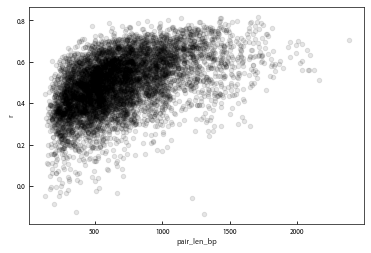

In [11]:
# Are longer pairs more strongly correlated? 
# I think we expect yes, but have to think through reasons.  
nosc_corr_df.plot.scatter('pair_len_bp', 'r', alpha=0.1, color='k')
linregress(pair_len_bp, nosc_corr_df.r)

In [3]:
all_nosc_vals = bac120_nosc_df.values.flatten()
all_nosc_vals = all_nosc_vals[~np.isnan(all_nosc_vals)]
all_nosc_vals

array([-0.14816038, -0.22451515, -0.27199764, ..., -0.17278399,
       -0.12612335, -0.21522908])

In [4]:
# Load the output from optimization runs where ZCred and ZCB are both varied
var_ZCB_df = pd.read_csv('../output/Fig3C_variable_ZCorg_var_ZCB.csv')
# Mask out the values computed without ATP homeostasis
tmp = var_ZCB_df[var_ZCB_df['opt.max_phi_H_set'] == False]

# Make a matrix of the maximum growth rate values for each pair of (ZCred,ZCB)
ZCred_ZCB_lambda_mat = tmp.pivot_table(index='ZCorg', columns='ZCB', values='lambda_hr')

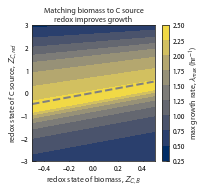

In [5]:
plt.figure(figsize=(2.75,2.5))
plt.contourf(ZCred_ZCB_lambda_mat.columns,
             ZCred_ZCB_lambda_mat.index,
             ZCred_ZCB_lambda_mat.values,
             cmap='cividis')
plt.colorbar(label='max growth rate, $\lambda_{max}$ (hr$^{-1}$)')

xs = np.arange(ZCred_ZCB_lambda_mat.columns.min(), ZCred_ZCB_lambda_mat.columns.max(), 0.01)
plt.plot(xs, xs, ls='--', color='grey')
plt.xlabel('redox state of biomass, $Z_{C,B}$')
plt.ylabel('redox state of C source, $Z_{C,red}$')
plt.title('Matching biomass to C source\nredox improves growth')
plt.savefig('../output/Fig3A.png', facecolor='w', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
# Load the output from optimization runs where ZCred and ZCB are both varied
var_ZCB_df = pd.read_csv('../output/Fig3C_variable_ZCorg_var_ZCB_max_C_uptake.csv')
# Mask out the values computed without ATP homeostasis
tmp = var_ZCB_df[var_ZCB_df['opt.max_phi_H_set'] == False]

# Make a matrix of the maximum growth rate values for each pair of (ZCred,ZCB)
index_cols = 'ZCorg,opt.max_C_uptake'.split(',')
ZCred_ZCB_lambda_mat_max_Cup = tmp.pivot_table(index=index_cols, columns='ZCB', values='lambda_hr')

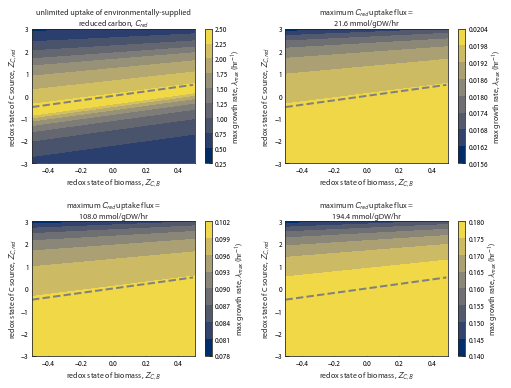

In [37]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(7.24,5.5))
flat_axs = axs.flatten()
max_Cups = ZCred_ZCB_lambda_mat_max_Cup.index.levels[1].unique()
vmin, vmax = ZCred_ZCB_lambda_mat_max_Cup.min().min(), ZCred_ZCB_lambda_mat_max_Cup.max().max()

for i, max_Cup in enumerate(max_Cups):
    plt.sca(flat_axs[i+1])

    # get the positions where the second index level (max C uptake) equals 3e-05
    idx = pd.IndexSlice
    tmp_mat = ZCred_ZCB_lambda_mat_max_Cup.loc[idx[:,max_Cup],:]
    plt.contourf(tmp_mat.columns,
                 tmp_mat.index.levels[0],
                 tmp_mat.values,
                 cmap='cividis')

    xs = np.arange(ZCred_ZCB_lambda_mat_max_Cup.columns.min(), ZCred_ZCB_lambda_mat_max_Cup.columns.max(), 0.01)
    plt.plot(xs, xs, ls='--', color='grey')
    plt.xlabel('redox state of biomass, $Z_{C,B}$')
    plt.ylabel('redox state of C source, $Z_{C,red}$')
    # max_Cup is in units of mol C/gC/s --> convert to mmol C/gDW/hr
    max_Cup_mmol_g_hr = max_Cup * 3600 * 1000
    plt.title('maximum $C_{{red}}$ uptake flux =\n{:.1f} mmol/gDW/hr'.format(
        max_Cup_mmol_g_hr))

    plt.colorbar(label='max growth rate, $\lambda_{max}$ (hr$^{-1}$)')

plt.sca(flat_axs[0])
plt.contourf(ZCred_ZCB_lambda_mat.columns,
             ZCred_ZCB_lambda_mat.index,
             ZCred_ZCB_lambda_mat.values,
             cmap='cividis')
plt.colorbar(label='max growth rate, $\lambda_{max}$ (hr$^{-1}$)')

xs = np.arange(ZCred_ZCB_lambda_mat.columns.min(), ZCred_ZCB_lambda_mat.columns.max(), 0.01)
plt.plot(xs, xs, ls='--', color='grey')
plt.xlabel('redox state of biomass, $Z_{C,B}$')
plt.ylabel('redox state of C source, $Z_{C,red}$')
plt.title('unlimited uptake of environmentally-supplied\nreduced carbon, $C_{red}}$')

plt.tight_layout()
plt.savefig('../output/Fig3A_max_C_uptake.png', facecolor='w', dpi=300, bbox_inches='tight')
plt.show()

0.7932624352511349 ile tRNA syn. ser tRNA syn.
0.4095090511505405 FtsY RadA
0.2022310253031126 RplO PPAT
0.0175372666307355 SecG RecA


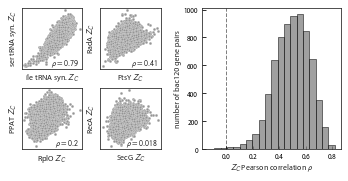

In [7]:
fig = plt.figure(figsize=(5, 2.6))
subfigs = fig.subfigures(nrows=1, ncols=2)
galleryAxs = subfigs[0].subplots(nrows=2, ncols=2)
axRight = subfigs[1].subplots(nrows=1, ncols=1)

pairs = ["TIGR00392,TIGR00414".split(','), "TIGR00064,TIGR00416".split(','),
         "TIGR01071,TIGR01510".split(','), 'TIGR00810,TIGR02012'.split(',') ]
pnames_dict = {
    'TIGR00392': 'ile tRNA syn.',
    'TIGR00414': 'ser tRNA syn.',
    'TIGR00810': 'SecG',
    'TIGR02012': 'RecA',
    'TIGR00064': 'FtsY',
    'TIGR00416': 'RadA',
    'TIGR01071': 'RplO',
    'TIGR01510': 'PPAT',  # pantetheine-phosphate adenylyltransferase
}
greys = sns.color_palette('Greys', n_colors=5)
for ax, gene_ids in zip(galleryAxs.flatten('C'), pairs):
    plt.sca(ax)

    sns.scatterplot(data=bac120_nosc_df, x=gene_ids[0], y=gene_ids[1], s=8, color=greys[2])

    desc0 = pnames_dict[gene_ids[0]]
    desc1 = pnames_dict[gene_ids[1]]
    label_fmt = '{0} $Z_C$'
    plt.xlabel(label_fmt.format(desc0), labelpad=3)
    plt.ylabel(label_fmt.format(desc1), labelpad=3)

    corr = nosc_corr_df.loc[gene_ids[0], gene_ids[1]].r
    print(corr, desc0, desc1)
    plt.text(0.95, 0.05, '$\\rho = {0:.2g}$'.format(corr), transform=plt.gca().transAxes, ha='right', fontsize=8)
    plt.xticks([])
    plt.yticks([])
    plt.tick_params(axis='both', which='both', length=0, pad=0)


plt.sca(axRight)
plt.axvline(0, color='grey', lw=1, ls='--', zorder=-1)
# Control in SI figure below. 
sns.histplot(data=nosc_corr_df.r, bins=20, color='grey', edgecolor='k', linewidth=0.5, label='raw')
plt.xlabel('$Z_C$ Pearson correlation $\\rho$')
plt.ylabel('number of bac120 gene pairs')

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.savefig('../output/Fig3BC.png', facecolor='w', dpi=300, bbox_inches='tight')
plt.show()

0.8000155057409526 RecG DNA primase
0.7932624352511349 ile tRNA syn. ser tRNA syn.
0.6499922476385853 Era RecG
0.5398362792149818 YqgF RecR
0.4095090511505405 FtsY RadA
0.2022310253031126 ribosomal protein uL15 PPAT
0.1198584950885396 SecG ribosomal protein uL13
0.0175372666307355 SecG RecA
-0.0584155890966763 SecG RNA pol $\beta$ subunit


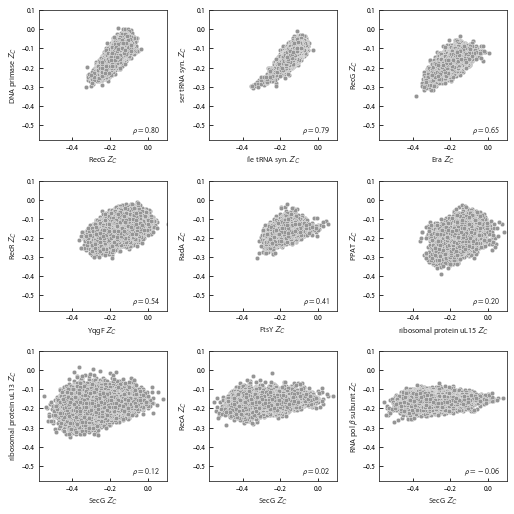

In [8]:
# Same as middle pannel above, but larger, with more examples and with ticks
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(7.24, 7.24))
pairs = ["TIGR00643,TIGR01391".split(','), "TIGR00392,TIGR00414".split(','), "TIGR00436,TIGR00643".split(','),
         "TIGR00250,TIGR00615".split(','), "TIGR00064,TIGR00416".split(','), "TIGR01071,TIGR01510".split(','),
         "TIGR00810,TIGR01066".split(','), "TIGR00810,TIGR02012".split(','), "TIGR00810,TIGR02386".split(',')]

pnames_dict = {
    'TIGR00392': 'ile tRNA syn.',
    'TIGR00414': 'ser tRNA syn.',
    'TIGR00810': 'SecG',
    'TIGR02012': 'RecA',
    'TIGR00064': 'FtsY',
    'TIGR00416': 'RadA',
    'TIGR01071': 'RplO',
    'TIGR01510': 'PPAT',  # pantetheine-phosphate adenylyltransferase
    'TIGR00643': 'RecG',
    'TIGR01391': 'DNA primase',
    'TIGR00436': 'Era',
    'TIGR00250': 'YqgF',
    'TIGR00615': 'RecR',
    'TIGR01071': 'ribosomal protein uL15',
    'TIGR01066': 'ribosomal protein uL13',
    'TIGR02386': 'RNA pol $\\beta$ subunit',
}
greys = sns.color_palette('Greys', n_colors=5)
for ax, gene_ids in zip(axs.flatten(), pairs):
    plt.sca(ax)
    sns.scatterplot(data=bac120_nosc_df, x=gene_ids[0], y=gene_ids[1], s=20, color=greys[2])

    desc0 = pnames_dict.get(gene_ids[0], 'gene')
    desc1 = pnames_dict.get(gene_ids[1], 'gene')
    label_fmt = '{0} $Z_C$'
    plt.xlabel(label_fmt.format(desc0), labelpad=3)
    plt.ylabel(label_fmt.format(desc1), labelpad=3)

    corr = nosc_corr_df.loc[gene_ids[0], gene_ids[1]].r
    print(corr, desc0, desc1)
    plt.text(0.95, 0.05, '$\\rho = {0:.2f}$'.format(corr), transform=plt.gca().transAxes, ha='right', fontsize=8)
    #plt.tick_params(axis='both', which='both', length=0, pad=0)
    plt.xlim(-0.58, 0.1)
    plt.ylim(-0.58, 0.1)
    
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.tight_layout()
plt.savefig('../output/FigSX_ZC_corr_gallery.png', facecolor='w', dpi=300,  bbox_inches='tight')
plt.show()

-0.15778975575545168 0.05524694077902046


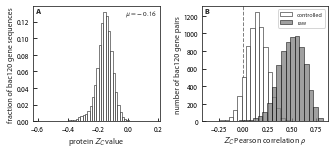

In [9]:
fig, axs = plt.subplots(ncols=2, figsize=(4.76, 2.25))

plt.sca(axs[0])
sns.histplot(data=all_nosc_vals, bins=50, color='w', edgecolor='k', linewidth=0.5, alpha=1.0, stat='proportion')
plt.xlabel('protein $Z_C$ value')
plt.ylabel('fraction of bac120 gene sequences')
mean = np.mean(all_nosc_vals)
std = np.std(all_nosc_vals)
plt.text(0.98, 0.98, '$\\mu = {0:.2f}$'.format(mean),
         transform=plt.gca().transAxes, ha='right', va='top', fontsize=7)
print(mean, std)

plt.sca(axs[1])
plt.axvline(0, color='grey', lw=1, ls='--', zorder=-1)
sns.histplot(data=nosc_corr_controlled_df.r, bins=20, color='w', edgecolor='k', linewidth=0.5, label='controlled', alpha=1.0)
sns.histplot(data=nosc_corr_df.r, bins=20, color='grey', edgecolor='k', linewidth=0.5, label='raw')
plt.xlabel('$Z_C$ Pearson correlation $\\rho$')
plt.ylabel('number of bac120 gene pairs')
plt.legend(loc=1)

panel_labels = 'AB'
for ax, label in zip(axs, panel_labels):
    plt.sca(ax)
    plt.text(0.02, 0.99, label, transform=plt.gca().transAxes, fontsize=8,
             va='top', fontweight='bold')

plt.tight_layout()
plt.savefig('../output/FigSX_controlled_corr.png')
plt.show()

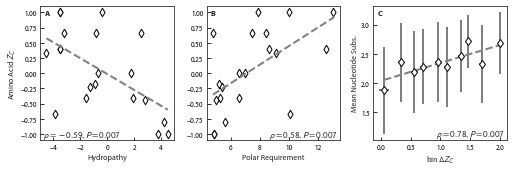

In [10]:
##### Supplementary Fig X -- genetic code is conservative for Z_C.

fig, axs = plt.subplots(ncols=3, figsize=(7.24, 2.5))

plt.sca(axs[0])

mask = np.logical_and(aa_nosc_df.hydropathy.notnull(),
                      aa_nosc_df.NOSC.notnull())
x = aa_nosc_df[mask].hydropathy
y = aa_nosc_df[mask].NOSC
reg = linregress(x, y)

pred_xs = np.arange(x.min(), x.max()*1.01, 0.1)
pred_y = reg.slope*pred_xs + reg.intercept

plt.scatter(x, y, marker='d', color='w', edgecolors='k', lw=1)
plt.plot(pred_xs, pred_y, marker='', ls='--', color='grey')
plt.text(0.02, 0.02, '$\\rho = {0:.2f}, P = {1:.1g}$'.format(reg.rvalue, reg.pvalue),
         ha='left', fontsize=9, transform=plt.gca().transAxes)
plt.xlabel('Hydropathy')
plt.ylabel('Amino Acid $Z_C$')

plt.sca(axs[1])

mask = np.logical_and(aa_nosc_df.polar_requirement.notnull(),
                      aa_nosc_df.NOSC.notnull())
x = aa_nosc_df[mask].polar_requirement
y = aa_nosc_df[mask].NOSC
reg = linregress(x, y)

pred_xs = np.arange(x.min(), x.max()*1.01, 0.1)
pred_y = reg.slope*pred_xs + reg.intercept

plt.scatter(x, y, marker='d', color='w', edgecolors='k', lw=1)
plt.plot(pred_xs, pred_y, marker='', ls='--', color='grey')
plt.text(0.98, 0.02, '$\\rho = {0:.2f}, P = {1:.1g}$'.format(reg.rvalue, reg.pvalue),
         ha='right', fontsize=9, transform=plt.gca().transAxes)
plt.xlabel('Polar Requirement')

plt.sca(axs[2])
codon_subs_mean_df = pd.read_csv('../data/genetic_code/binned_codon_substitutions.csv', index_col=0)
x = codon_subs_mean_df.abs_dNOSC
y = codon_subs_mean_df.hamming_dist
reg = linregress(x, y)

pred_xs = np.arange(x.min(), x.max()*1.01, 0.01)
pred_y = reg.slope*pred_xs + reg.intercept

# hamming distance of codon substitution vs. change in NOSC
# note: symmetric confidence intervals are weird here. can't have > 3 subs
# TODO: consider non-symmetric
plt.errorbar(x, y, xerr=codon_subs_mean_df.abs_dNOSC_std, yerr=codon_subs_mean_df.hamming_dist_std, 
             marker='d', markeredgecolor='k', color='w', ls='', ecolor='grey')
plt.plot(pred_xs, pred_y, marker='', ls='--', color='grey')
plt.text(0.98, 0.03, '$\\rho = {0:.2f}, P = {1:.1g}$'.format(reg.rvalue, reg.pvalue),
         ha='right', fontsize=9, transform=plt.gca().transAxes)
plt.xlabel('bin $\Delta Z_C$')
plt.ylabel('Mean Nucleotide Subs.')

panel_labels = 'ABC'
for ax, label in zip(axs, panel_labels):
    plt.sca(ax)
    plt.text(0.03, 0.98, label, transform=plt.gca().transAxes, fontsize=8,
             va='top', fontweight='bold')

plt.tight_layout()
plt.savefig('../output/FigSX_genetic_code.png', facecolor='w', dpi=300)
plt.show()

In [11]:
# calculate the interval including the middle 99% of correlations
np.quantile(nosc_corr_df.r, [0.005, 0.995])

array([0.07737205, 0.76697797])